## Importations

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
import PIL.Image

from glob import glob
import itertools
import os

os.environ['AUTOGRAPH_VERBOSITY'] = '0'

tf.autograph.set_verbosity(0)

%pip install opendatasets
import opendatasets

from psutil import virtual_memory


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\Programming\Portfolio_Projects\Classification_VGG_RESNET\venv\Scripts\python.exe -m pip install --upgrade pip' command.


## Importing dataset through kaggle

In [2]:
opendatasets.download("https://www.kaggle.com/datasets/paultimothymooney/blood-cells/")

Skipping, found downloaded files in ".\blood-cells" (use force=True to force download)


In [3]:
# Check if we are running in colab
running_colab = False

if 'google.colab' in str(get_ipython()):
  running_colab = True  
  print('Running on CoLab')

  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)
    
  ram_gb = virtual_memory().total / 1e9
  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

  if ram_gb < 20:
    print('Not using a high-RAM runtime')
  else:
    print('You are using a high-RAM runtime!')


In [4]:
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [5]:
# Paths
if running_colab:
    directory = '/content/blood-cells/dataset2-master/dataset2-master/images'
else:
    directory = 'blood-cells\dataset2-master\dataset2-master\images'

train_path = os.path.join(directory, "TRAIN")
valid_path = os.path.join(directory, "TEST")

# Files
train_image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')
folders = glob(train_path + '/*')   # ie number of classes 

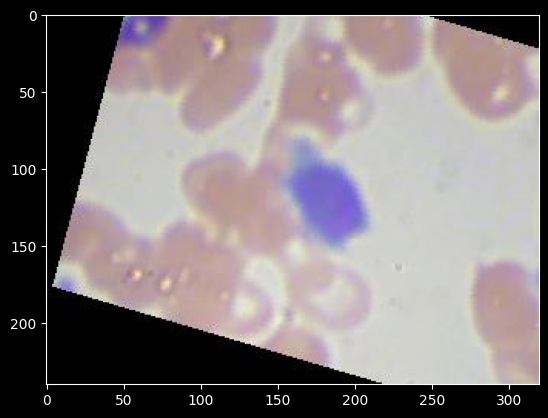

In [6]:
random_image = tf.keras.preprocessing.image.load_img(np.random.choice(train_image_files))
plt.imshow(random_image)
plt.show()

In [7]:
# Configuration

IMAGE_SIZE  = list(random_image.size)
EPOCHS      = 25
BATCH_SIZE  = 128

## VGG

In [8]:
# GPU scope
with strategy.scope():
    # Importing the VGG weights from imagenet; Transfer learning => include_top = false
    vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

    # Setting all the layers as not trainable
    for layer in vgg.layers:
        layer.trainable = False
        
    # Classifier layers
    x = Flatten()(vgg.output)
    prediction = Dense(len(folders), activation='softmax')(x)

    # Model instance
    vgg_model = Model(inputs=vgg.input, outputs=prediction)
    vgg_model.summary()
    vgg_model.compile(
        loss='categorical_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy']
    )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 320, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 320, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 160, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 160, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 160, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 80, 60, 128)       0     

## ResNet Architecture

In [9]:
with strategy.scope():
    resnet = ResNet50(input_shape=IMAGE_SIZE + [3], include_top=False, weights='imagenet')
    
    for layer in resnet.layers:
        layer.trainable = False
        
    x = Flatten()(resnet.output)
    predictions = Dense(len(folders), activation='softmax')(x)
    
    resnet_model = Model(inputs=resnet.inputs, outputs=predictions)
    resnet_model.summary()
    resnet_model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam',
        metrics=['accuracy']
    )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape

In [10]:
# Instance of Image Data Generator
generator = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

In [11]:
# Train and validation generators
from random import shuffle


train_generator = generator.flow_from_directory(
    train_path, 
    target_size=IMAGE_SIZE, 
    shuffle=True, 
    batch_size=BATCH_SIZE
)

valid_generator = generator.flow_from_directory(
    valid_path, 
    target_size=IMAGE_SIZE, 
    shuffle=True, 
    batch_size=BATCH_SIZE
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [12]:
# Train models
with strategy.scope():

    vgg_history = vgg_model.fit(
        train_generator, 
        validation_data=valid_generator, 
        epochs=EPOCHS, 
        steps_per_epoch=len(train_image_files) // BATCH_SIZE, 
        validation_steps = len(valid_image_files) // BATCH_SIZE, 
        verbose=1, 
        callbacks=[
           tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        ] 
    )
    
    resnet_history = resnet_model.fit(
        train_generator, 
        validation_data=valid_generator, 
        epochs=EPOCHS, 
        steps_per_epoch=len(train_image_files) // BATCH_SIZE, 
        validation_steps = len(valid_image_files) // BATCH_SIZE, 
        verbose=1, 
        callbacks=[
           tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        ]
    )

Epoch 1/16
155/155 [==============================] - 294s 2s/step - loss: 24.0999 - accuracy: 0.4433 - val_loss: 16.8480 - val_accuracy: 0.4424
Epoch 2/16
155/155 [==============================] - 231s 1s/step - loss: 14.6512 - accuracy: 0.5940 - val_loss: 16.2659 - val_accuracy: 0.4967
Epoch 3/16
155/155 [==============================] - 230s 1s/step - loss: 11.9192 - accuracy: 0.6545 - val_loss: 20.1994 - val_accuracy: 0.4889
Epoch 4/16
155/155 [==============================] - 233s 2s/step - loss: 10.4718 - accuracy: 0.7040 - val_loss: 19.1280 - val_accuracy: 0.4926
Epoch 5/16
155/155 [==============================] - 239s 2s/step - loss: 9.6670 - accuracy: 0.7242 - val_loss: 20.5650 - val_accuracy: 0.4963
Epoch 6/16
155/155 [==============================] - 230s 1s/step - loss: 9.0672 - accuracy: 0.7488 - val_loss: 28.0529 - val_accuracy: 0.4700
Epoch 1/16
155/155 [==============================] - 232s 1s/step - loss: 11.3402 - accuracy: 0.5247 - val_loss: 10.4556 - val_accu

In [13]:
# outputting the confusion matrix

def get_confusion_matrix(model, data_path, N):
    predictions = []
    targets     = []
    # from generators to numpy array
    for x, y in generator.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=BATCH_SIZE):
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets     = np.concatenate((targets, y))
        if len(targets) >= N:
            break
        
    matrix = confusion_matrix(targets, predictions)
    return matrix


vgg_training_confusion      = get_confusion_matrix(vgg_model, train_path, len(train_image_files))
resnet_training_confusion   = get_confusion_matrix(resnet_model, train_path, len(train_image_files))
print(vgg_training_confusion)
print(resnet_training_confusion)

Found 9957 images belonging to 4 classes.
2/2 [==============================] - 1s 1s/step
Found 9957 images belonging to 4 classes.
2/2 [==============================] - 2s 485ms/step
[[ 898  123  357 1119]
 [  24 2017  129  313]
 [   8   17 2293  160]
 [  35   53  133 2278]]
[[2195   25   11  266]
 [ 725 1465   26  267]
 [ 456   13 1775  234]
 [ 720   32   16 1731]]


In [14]:
vgg_validation_confusion      = get_confusion_matrix(vgg_model, valid_path, len(valid_image_files))
resnet_validation_confusion   = get_confusion_matrix(resnet_model, valid_path, len(valid_image_files))
print(vgg_validation_confusion)
print(resnet_validation_confusion)


Found 2487 images belonging to 4 classes.


ResourceExhaustedError: Graph execution error:

Detected at node 'model/block1_conv2/Conv2D' defined at (most recent call last):
    File "C:\Users\natha\AppData\Local\Programs\Python\Python39\lib\threading.py", line 908, in _bootstrap
      self._bootstrap_inner()
    File "C:\Users\natha\AppData\Local\Programs\Python\Python39\lib\threading.py", line 950, in _bootstrap_inner
      self.run()
    File "d:\Programming\Portfolio_Projects\Classification_VGG_RESNET\venv\lib\site-packages\keras\engine\training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "d:\Programming\Portfolio_Projects\Classification_VGG_RESNET\venv\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
      return self(x, training=False)
    File "d:\Programming\Portfolio_Projects\Classification_VGG_RESNET\venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "d:\Programming\Portfolio_Projects\Classification_VGG_RESNET\venv\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "d:\Programming\Portfolio_Projects\Classification_VGG_RESNET\venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "d:\Programming\Portfolio_Projects\Classification_VGG_RESNET\venv\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\Programming\Portfolio_Projects\Classification_VGG_RESNET\venv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "d:\Programming\Portfolio_Projects\Classification_VGG_RESNET\venv\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "d:\Programming\Portfolio_Projects\Classification_VGG_RESNET\venv\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "d:\Programming\Portfolio_Projects\Classification_VGG_RESNET\venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "d:\Programming\Portfolio_Projects\Classification_VGG_RESNET\venv\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\Programming\Portfolio_Projects\Classification_VGG_RESNET\venv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "d:\Programming\Portfolio_Projects\Classification_VGG_RESNET\venv\lib\site-packages\keras\layers\convolutional\base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "d:\Programming\Portfolio_Projects\Classification_VGG_RESNET\venv\lib\site-packages\keras\layers\convolutional\base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'model/block1_conv2/Conv2D'
OOM when allocating tensor with shape[32,64,320,240] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/block1_conv2/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_28911]

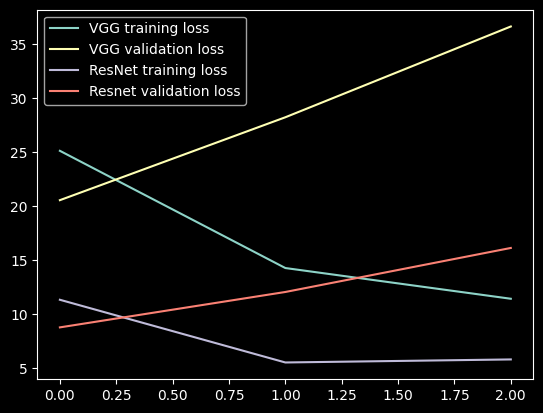

In [ ]:
# plotting losses
plt.plot(vgg_history.history['loss'], label='VGG training loss')
plt.plot(vgg_history.history['val_loss'], label='VGG validation loss')
plt.plot(resnet_history.history['loss'], label='ResNet training loss')
plt.plot(resnet_history.history['val_loss'], label='Resnet validation loss')
plt.legend()
plt.show()

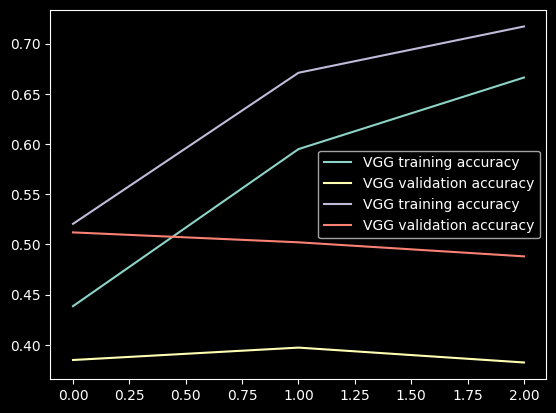

In [ ]:
# plotting accuracy
plt.plot(vgg_history.history['accuracy'], label='VGG training accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='VGG validation accuracy')
plt.plot(resnet_history.history['accuracy'], label='Resnet training accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Resnet validation accuracy')
plt.legend()
plt.show()